### Load packages and variables

Use the  conda env Lulu with the following pip installs:  
pip install nb_black

In [1]:
from gimmemotifs.preprocessing import combine_peaks
from gimmemotifs.preprocessing import coverage_table

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import subprocess as sp
import qnorm
import gseapy as gp

os.chdir("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/scripts")
# from Python_scripts import bedtool_closest
# from Python_scripts import coverage_table_normalization
from Python_scripts import Ensemble2UCSC
from Python_scripts import genome_TSS_annotation
from Python_scripts import TSS_window_to_region
from Python_scripts import distance_weight

# from Python_scripts import genome_TSS_annotation_prom
from Python_scripts import summits_2_regions


plt.style.use("classic")
%matplotlib inline
#%load_ext nb_black
#%reload_ext nb_black

In [5]:
def Ensemble2UCSC(chr_list, db_location, to_ID_type):
    """
    chr_list = "list of chr identifiers, or chr locations (either "1" or "1:1002-3999") that need
    to be converted (into "chr1" or "chr1:1002-3999")
    db_location = "tab seperated identifier linking file"
    to_ID_type = either 'Ensmble' or UCSC, converts te other to the target ID type.

    """
    table = pd.read_table(Ensembl2UCSC_ids)
    if to_ID_type == "Ensemble":
        table = dict(zip(table.ensembl, table.UCSC))
    elif to_ID_type == "UCSC":
        table = dict(zip(table.UCSC, table.ensembl))
    else:
        print("either put Ensemble or UCSC as the to_ID_type input")

    new_ids = []

    if all(chr_list.str.contains(":")):
        print("list contains the ':' symbol, replacing chrom ids in front of :")
        for line in chr_list:
            chrom = line.split(":")[0]
            coordinate = line.split(":")[1]
            #print(chrom)
            chrom = table.get(str(chrom))
            #print(chrom)
            if chrom == None:
                chrom = 'missing_scaffold'
            new_ids.append(chrom + ":" + coordinate)
    else:
        print("no ':' symbol found, asuming only 1 chrom id per line")
        for line in chr_list:
            new_ids.append(table.get(line))

    return new_ids


def make_bedfile_from_column(df, column_name, filename):
    """
    df: a df containing a column with : chr1:100-1000 (or 1:100-1000)
    column_name: the name of the column with the loc ids that need to be exported to a bed file
    filename: bedfile the location will be exported to.
    """
    df[["chrom", "chromStart", "chromEnd"]] = df.loc[:,column_name].str.split(
       "[:-]", expand=True
     )
    df = df.loc[:, ["chrom", "chromStart", "chromEnd"]]
    df.to_csv(
    filename, sep="\t", header=False, index=False
)



In [3]:
analysis_dir = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/PAX6_chipseq/"
output_dir = analysis_dir + str("2023-13-06")
log_dir = f"{output_dir}/logs"
figure_dir = f"{output_dir}/figures"

Path(figure_dir).mkdir(parents=True, exist_ok=True)
Path(log_dir).mkdir(parents=True, exist_ok=True)

# Use the conda environment 'gimme' for this analysis, all the installed packages are outputed to the output dir.
#!/vol/mbconda/jsmits/condabin/conda list > {log_dir}/conda_env.txt

# load all the file locations for this analysis from the file location file
files = pd.read_table(
    f"{analysis_dir}/files.csv", sep=";", header=None, comment="#", index_col=0
).T

### Merge the PAX6 chipseq peaks

Lets first only select the PAX6 peaks that were measured in both replica's

In [6]:
sp.check_call(
    f"bedtools intersect -a {files.PAX6_peaks_1[1]} -b {files.PAX6_peaks_2[1]} -wo > {output_dir}/common_PAX6_peaks.bed",
    shell=True,
)

# after merging, the bedfile basically consist of all the overlappnig peaks, with the first 10 columns the peak info from fila A
# And the next 10 columns the peak info of file B. Since all the peaks are overlapping in 2 replica's, lets merge the peaks
# And select the highest summit.

PAX6_peak_combined = pd.read_table(
    f"{output_dir}/common_PAX6_peaks.bed", sep="\t", comment="#", header=None
)

PAX6_peak_combined.iloc[:, 0:10].to_csv(
    f"{output_dir}/common_PAX6_peaks_file1.narrowPeak",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep="\t",
    header=False,
    index=False,
)
PAX6_peak_combined.iloc[:, 10:20].to_csv(
    f"{output_dir}/common_PAX6_peaks_file2.narrowPeak",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep="\t",
    header=False,
    index=False,
)

In [7]:
PAX6_peaks = combine_peaks(
    [
        f"{output_dir}/common_PAX6_peaks_file1.narrowPeak",
        f"{output_dir}/common_PAX6_peaks_file2.narrowPeak",
    ],
    files.genome_path_size[1],
    int(200),
    True,
)

Ensembl2UCSC_ids = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/scripts/CRCH38_ensembl2UCSC.txt"
PAX6_peaks["Chrom_UCSC"] = Ensemble2UCSC(
    PAX6_peaks["chrom"], Ensembl2UCSC_ids, "UCSC"
)  # turn the chrom coordinates to Ensembl

PAX6_peaks = PAX6_peaks[~PAX6_peaks.Chrom_UCSC.str.contains("GL|Un|KI|MT|X|Y|M")]

PAX6_peaks[["Chrom_UCSC", "start", "end"]].to_csv(
    f"{output_dir}/PAX6_UCSC_summits.bed",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep="\t",
    header=False,
    index=False,
)
PAX6_peaks[["chrom", "start", "end"]].to_csv(
    f"{output_dir}/PAX6_summits.bed",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep="\t",
    header=False,
    index=False,
)

no ':' symbol found, asuming only 1 chrom id per line


# For the FOSL2 samples lets use the peaks of the deeper sequenced sample

In [6]:
#FOSL2_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/macs2/GRCh38.p13-CL_J3-4_FOSL2_R2_S13_L001_summits.bed'
FOSL2_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/macs2/GRCh38.p13-LSC_FOSL2_summits.bed'

FOSL2_summits = pd.read_table(FOSL2_summit_file,sep="\t",comment="#",names=['chrom','start','end','stuf','strand'])
#FOSL2_summits['start'] = FOSL2_summits['start'] - 100
#FOSL2_summits['end'] = FOSL2_summits['end']  + 99
FOSL2_peaks = FOSL2_summits[['chrom','start','end']]
FOSL2_peaks = FOSL2_peaks[~FOSL2_peaks.chrom.str.contains("GL|Un|KI|MT|X|Y|M")]

FOSL2_peaks[["chrom", "start", "end"]].to_csv(
    f"{output_dir}/FOSL2_UCSC_summits.bed",
    sep="\t",
    header=False,
    index=False,
)

UCSC2Ensembl_ids = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/scripts/CRCH38_UCSC2ensembl.txt"
Ensembl2UCSC_ids = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/scripts/CRCH38_ensembl2UCSC.txt"

FOSL2_peaks["chrom_ensembl"] = Ensemble2UCSC(
    FOSL2_peaks["chrom"], Ensembl2UCSC_ids, "Ensemble"
)  # turn the chrom coordinates to Ensembl

FOSL2_peaks[["chrom_ensembl", "start", "end"]].to_csv(
    f"{output_dir}/FOSL2_summits.bed",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep="\t",
    header=False,
    index=False,
)

no ':' symbol found, asuming only 1 chrom id per line


# Quantify chipseq signals

Lets first perform some basic QC for the PAX6 chipseq dataset:  

n_peaks = 60.000!<br>
FRIP = (s2s rerun,tbd)  

Lets perform motif analysis on the chipseq regions to check if we will find a PAX6 motif

In [16]:
# Quantify both the PAX6 chipseq intensity, and the H3K27ac signal arround PAX6 binding locations:
for chip, window, bamfiles in zip(["PAX6", "H3K27ac"], [200, 2000],[[files.PAX6_bam_1[1], files.PAX6_bam_2[1]],[files.H3K27ac_bam_1[1], files.H3K27ac_bam_2[1],files.H3K27ac_bam_3[1]]]):
    # make a 200bp window for quantifying the PAX6 chipseq signal:
    summits_2_regions(
        f"{output_dir}/PAX6_summits.bed",
        f"{output_dir}/PAX6_{window}bp.bed",
        int(window),
    )

    # Run coverage table to quantify the chip signal in the windows:
    
    if os.path.exists(f"{output_dir}/{chip}_intensity.csv"): 
        print(f'loading the previously ran coverage table data')

    else:
        print(f'running coverage table for the {chip}')
        print(f'{bamfiles}')
        mark_intensity = coverage_table(
            peakfile=f"{output_dir}/PAX6_{window}bp.bed",
            datafiles=bamfiles,
            window=int(window),
            log_transform=None,
            ncpus=int(14),
        )
        # concatinate the reads, and perform quantile based normalization
        mark_intensity[f"{chip}_reads_concatinated"] = mark_intensity.sum(axis=1)
        mark_intensity[f"{chip}_qnorm"] = qnorm.quantile_normalize(
            np.log10(mark_intensity[[f"{chip}_reads_concatinated"]]+1)
        )
        mark_intensity[f"{chip}_window"] = mark_intensity.index
        mark_intensity[["Chrom", "ChromStart", "ChromEnd"]] = mark_intensity[
        f"{chip}_window"
    ].str.split("[:-]", expand=True)
        
        
        mark_intensity["ChromStart"] = (mark_intensity["ChromStart"].astype(int) + (window/2)).astype(int)
        mark_intensity["ChromEnd"] = (mark_intensity["ChromEnd"].astype(int) - ((window/2)-1)).astype(int)
        mark_intensity["Chrom_UCSC"] = Ensemble2UCSC(
        mark_intensity["Chrom"], Ensembl2UCSC_ids, "UCSC"
    )  # turn the chrom coordinates to Ensembl

        mark_intensity[f"{chip}_peak_summit"] = (
            mark_intensity["Chrom_UCSC"].astype(str)
            + ":"
            + mark_intensity["ChromStart"].astype(str)
            + "-"
            + mark_intensity["ChromEnd"].astype(str)
        )

        mark_intensity.to_csv(
        f"{output_dir}/{chip}_intensity.csv",
        # f"{output_dir}/H3K27me3_TSS_window.bed",
        sep=",",
        header=True,
        index=False,
    )
        
#lets output the results


loading the previously ran coverage table data
loading the previously ran coverage table data


In [17]:
#lets output the results
PAX6_int = pd.read_table(
    f"{output_dir}/PAX6_intensity.csv",
    sep=",",
    comment="#",
)
H3K27ac_int = pd.read_table(
    f"{output_dir}/H3K27ac_intensity.csv",
    sep=",",
    comment="#",
)
PAX6_H3K27ac_Int = PAX6_int[["PAX6_peak_summit", "PAX6_qnorm"]].merge(
    H3K27ac_int[["H3K27ac_peak_summit", "H3K27ac_qnorm"]],
    left_on="PAX6_peak_summit",
    right_on="H3K27ac_peak_summit",
)
PAX6_H3K27ac_Int[["Chrom", "ChromStart", "ChromEnd"]] = PAX6_H3K27ac_Int[
    "PAX6_peak_summit"
].str.split("[:-]", expand=True)

PAX6_H3K27ac = PAX6_H3K27ac_Int.sort_values(by="PAX6_qnorm", ascending=False)
PAX6_H3K27ac.to_csv(
    f"{output_dir}/PAX6_and_H3K27ac_intensity.txt",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep="\t",
    header=False,
    index=False,
)

# Lets do the same for the FOSL2 data

In [8]:
FOSL2_bam1 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3_4_FOSL2_R1_final.samtools-coordinate.bam"
FOSL2_bam2 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3-4_FOSL2_R2_S13_L001.samtools-coordinate.bam"

# Quantify both the PAX6 chipseq intensity, and the H3K27ac signal arround PAX6 binding locations:
for chip, window, bamfiles in zip(["FOSL2", "H3K27AC"], [200, 2000],[[FOSL2_bam1,FOSL2_bam2],[files.H3K27ac_bam_1[1], files.H3K27ac_bam_2[1],files.H3K27ac_bam_3[1]]]):
    # make a 200bp window for quantifying the PAX6 chipseq signal:
    
    summits_2_regions(
        f"{output_dir}/FOSL2_UCSC_summits.bed",
        f"{output_dir}/FOSL2_{window}_UCSCbp.bed",
        int(window),
    )
    summits_2_regions(
        f"{output_dir}/FOSL2_summits.bed",
        f"{output_dir}/FOSL2_{window}bp.bed",
        int(window),
    )
    # Run coverage table to quantify the chip signal in the windows:
    if os.path.exists(f"{output_dir}/{chip}_intensity.csv"): 
        print(f'loading the previously ran coverage table data')

    else:
        print(f'running coverage table for the {chip}')
        print(f'{bamfiles}')
        if chip == 'FOSL2':
            mark_intensity = coverage_table(
                peakfile=f"{output_dir}/FOSL2_UCSC_summits.bed",
                datafiles=bamfiles,
                window=int(window),
                log_transform=None,
                ncpus=int(14),
            )
            mark_intensity.index = Ensemble2UCSC(mark_intensity.index, Ensembl2UCSC_ids, 'Ensemble')
        else:       
            mark_intensity = coverage_table(
                peakfile=f"{output_dir}/FOSL2_{window}bp.bed",
                datafiles=bamfiles,
                window=int(window),
                log_transform=None,
                ncpus=int(14),
            )
        # concatinate the reads, and perform quantile based normalization
        mark_intensity[f"{chip}_reads_concatinated"] = mark_intensity.sum(axis=1)
        mark_intensity[f"{chip}_qnorm"] = qnorm.quantile_normalize(
            np.log10(mark_intensity[[f"{chip}_reads_concatinated"]]+1)
        )
        mark_intensity[f"{chip}_window"] = mark_intensity.index
        mark_intensity[["Chrom", "ChromStart", "ChromEnd"]] = mark_intensity[
        f"{chip}_window"
    ].str.split("[:-]", expand=True)
        
        
        mark_intensity["ChromStart"] = (mark_intensity["ChromStart"].astype(int) + (window/2)).astype(int)
        mark_intensity["ChromEnd"] = (mark_intensity["ChromEnd"].astype(int) - ((window/2)-1)).astype(int)
        mark_intensity["Chrom_UCSC"] = Ensemble2UCSC(
        mark_intensity["Chrom"], Ensembl2UCSC_ids, "UCSC"
    )  # turn the chrom coordinates to Ensembl

        mark_intensity[f"{chip}_peak_summit"] = (
            mark_intensity["Chrom_UCSC"].astype(str)
            + ":"
            + mark_intensity["ChromStart"].astype(str)
            + "-"
            + mark_intensity["ChromEnd"].astype(str)
        )

        mark_intensity.to_csv(
        f"{output_dir}/{chip}_intensity.csv",
        # f"{output_dir}/H3K27me3_TSS_window.bed",
        sep=",",
        header=True,
        index=False,
    )


2023-07-03 17:12:25,816 - INFO - Loading data


running coverage table for the FOSL2
['/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3_4_FOSL2_R1_final.samtools-coordinate.bam', '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3-4_FOSL2_R2_S13_L001.samtools-coordinate.bam']


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-03 17:12:39,342 - INFO - No normalization


list contains the ':' symbol, replacing chrom ids in front of :
no ':' symbol found, asuming only 1 chrom id per line


2023-07-03 17:12:41,130 - INFO - Loading data


running coverage table for the H3K27AC
['/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/H3K27ac/results/final_bam/hg38-Chipseq_LSC_PRIM_H3K27ac.samtools-coordinate.bam', '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/H3K27ac/results/final_bam/hg38-GSM4728063.samtools-coordinate.bam', '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/H3K27ac/results/final_bam/hg38-GSM4728064.samtools-coordinate.bam']


  0%|          | 0/3 [00:00<?, ?it/s]

2023-07-03 17:13:48,814 - INFO - No normalization


no ':' symbol found, asuming only 1 chrom id per line


In [9]:
#lets output the results
FOSL2_int = pd.read_table(
    f"{output_dir}/FOSL2_intensity.csv",
    sep=",",
    comment="#",
)
H3K27ac_int = pd.read_table(
    f"{output_dir}/H3K27AC_intensity.csv",
    sep=",",
    comment="#",
)
FOSL2_H3K27ac_Int = FOSL2_int[["FOSL2_peak_summit", "FOSL2_qnorm"]].merge(
    H3K27ac_int[["H3K27AC_peak_summit", "H3K27AC_qnorm"]],
    left_on="FOSL2_peak_summit",
    right_on="H3K27AC_peak_summit",
)
FOSL2_H3K27ac_Int[["Chrom", "ChromStart", "ChromEnd"]] = FOSL2_H3K27ac_Int[
    "FOSL2_peak_summit"
].str.split("[:-]", expand=True)

FOSL2_H3K27ac = FOSL2_H3K27ac_Int.sort_values(by="FOSL2_qnorm", ascending=False)
FOSL2_H3K27ac.to_csv(
    f"{output_dir}/FOSL2_and_H3K27ac_intensity.txt",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep="\t",
    header=True,
    index=False,
)

Next, let overlap all TSS regions with 100kb windows, to find out which genes have a PAX6 peak within 100kb, and how far away that peak is.

In [18]:
TSS_window2_CRE = TSS_window_to_region(
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/GRCh38.p13/GRCh38.p13.annotation.small.gtf",
    f"{output_dir}/PAX6_UCSC_summits.bed",
    TSS_window=50000,
)

TSS_window2_CRE["PAX6_peak_summit"] = (
    TSS_window2_CRE["Chrom"].astype(str)
    + ":"
    + TSS_window2_CRE["ChromStart"].astype(str)
    + "-"
    + TSS_window2_CRE["ChromEnd"].astype(str)
)
PAX6_2_TSS = TSS_window2_CRE.merge(PAX6_H3K27ac, how="left", on="PAX6_peak_summit")


and agian the same for the FOSL2 chipseq

In [10]:
TSS_window2_CRE = TSS_window_to_region(
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/GRCh38.p13/GRCh38.p13.annotation.small.gtf",
    f"{output_dir}/FOSL2_UCSC_summits.bed",
    TSS_window=50000,
)

TSS_window2_CRE["FOSL2_peak_summit"] = (
    TSS_window2_CRE["Chrom"].astype(str)
    + ":"
    + TSS_window2_CRE["ChromStart"].astype(str)
    + "-"
    + TSS_window2_CRE["ChromEnd"].astype(str)
)
FOSL2_2_TSS = TSS_window2_CRE.merge(FOSL2_H3K27ac,how="left", on="FOSL2_peak_summit")

# distance weight the PAX6 & H3K27ac intensities


In [19]:
sns.set(rc={"figure.figsize": (15, 3)})
# import from Ananse
weight = distance_weight(alpha=1e4, include_promoter=False)
enh_weight_dict = pd.Series(weight.weight.values, index=weight.dist).to_dict()

weight = distance_weight(alpha=1e4, include_promoter=True, include_enhancer = False)
prom_weight_dict = pd.Series(weight.weight.values, index=weight.dist).to_dict()

weight = distance_weight(alpha=1e4, include_promoter=True, include_enhancer = True)
all_weight_dict = pd.Series(weight.weight.values, index=weight.dist).to_dict()

In [20]:
PAX6_2_TSS["enh_weight"] = PAX6_2_TSS["distance"].map(enh_weight_dict)
PAX6_2_TSS["prom_weight"] = PAX6_2_TSS["distance"].map(prom_weight_dict)
PAX6_2_TSS["both_weight"] = PAX6_2_TSS["distance"].map(all_weight_dict)

# distance weight the ATAC and H3K27ac basemean and FC values
PAX6_2_TSS["PAX6_enh_weighted_int"] = (
    PAX6_2_TSS[["PAX6_qnorm"]]
    .astype(float)
    .multiply(PAX6_2_TSS["enh_weight"], axis="index")
)

PAX6_2_TSS["H3K27ac_enh_weighted_int"] = (
    PAX6_2_TSS["H3K27ac_qnorm"]
    .astype(float)
    .multiply(PAX6_2_TSS["enh_weight"], axis="index")
)
PAX6_2_TSS["H3K27ac_prom_weighted_int"] = (
    PAX6_2_TSS["H3K27ac_qnorm"]
    .astype(float)
    .multiply(PAX6_2_TSS["prom_weight"], axis="index")
)
PAX6_2_TSS["H3K27ac_both_weighted_int"] = (
    PAX6_2_TSS["H3K27ac_qnorm"]
    .astype(float)
    .multiply(PAX6_2_TSS["both_weight"], axis="index")
)
PAX6_2_TSS["PAX6_prom_weighted_int"] = (
    PAX6_2_TSS[["PAX6_qnorm"]]
    .astype(float)
    .multiply(PAX6_2_TSS["prom_weight"], axis="index")
)

PAX6_2_TSS["PAX6_both_weighted_int"] = (
    PAX6_2_TSS[["PAX6_qnorm"]]
    .astype(float)
    .multiply(PAX6_2_TSS["both_weight"], axis="index")
)


# merge the multiple PAX6 peak signals together
TSS_PAX6_int = (
    PAX6_2_TSS[
        [
            "gene_name",
            "PAX6_enh_weighted_int",
            "H3K27ac_enh_weighted_int",
            "H3K27ac_prom_weighted_int",
            "PAX6_prom_weighted_int",
            "PAX6_both_weighted_int",
            "H3K27ac_both_weighted_int",
        ]
    ]
    .groupby(["gene_name"])
    .agg(["sum", "count"])
    # .sum()
    .reset_index()
)
TSS_PAX6_int.columns = TSS_PAX6_int.columns.droplevel()
TSS_PAX6_int.columns = [
    [
        "gene_name",
        "PAX6_enh_int",
        "n_enh",
        "H3K27ac_enh_weighted_int",
        "n_enh2",
        "H3K27ac_prom_weighted_int",
        "n_enh5",
        "PAX6_prom_int",
        "n_prom",
        "PAX6_both_weighted_int",
        "n_enh3",
        "H3K27ac_both_weighted_int",
        "n_enh4",
    ]
]
TSS_PAX6_int = TSS_PAX6_int.drop(
    ["n_enh2", "n_prom", "n_enh3", "n_enh4", "n_enh5"], axis=1
)
TSS_PAX6_int.to_csv(
    f"{output_dir}/TSS_PAX6_binding_intensity.csv",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep=";",
    header=True,
    index=False,
)

And the same for FOSL2

In [21]:
FOSL2_2_TSS["enh_weight"] = FOSL2_2_TSS["distance"].map(enh_weight_dict)
FOSL2_2_TSS["prom_weight"] = FOSL2_2_TSS["distance"].map(prom_weight_dict)
FOSL2_2_TSS["both_weight"] = FOSL2_2_TSS["distance"].map(all_weight_dict)

# distance weight the ATAC and H3K27ac basemean and FC values
FOSL2_2_TSS["FOSL2_enh_weighted_int"] = (
    FOSL2_2_TSS[["FOSL2_qnorm"]]
    .astype(float)
    .multiply(FOSL2_2_TSS["enh_weight"], axis="index")
)

FOSL2_2_TSS["H3K27AC_enh_weighted_int"] = (
    FOSL2_2_TSS["H3K27AC_qnorm"]
    .astype(float)
    .multiply(FOSL2_2_TSS["enh_weight"], axis="index")
)
FOSL2_2_TSS["H3K27AC_prom_weighted_int"] = (
    FOSL2_2_TSS["H3K27AC_qnorm"]
    .astype(float)
    .multiply(FOSL2_2_TSS["prom_weight"], axis="index")
)
FOSL2_2_TSS["H3K27AC_both_weighted_int"] = (
    FOSL2_2_TSS["H3K27AC_qnorm"]
    .astype(float)
    .multiply(FOSL2_2_TSS["both_weight"], axis="index")
)
FOSL2_2_TSS["FOSL2_prom_weighted_int"] = (
    FOSL2_2_TSS[["FOSL2_qnorm"]]
    .astype(float)
    .multiply(FOSL2_2_TSS["prom_weight"], axis="index")
)

FOSL2_2_TSS["FOSL2_both_weighted_int"] = (
    FOSL2_2_TSS[["FOSL2_qnorm"]]
    .astype(float)
    .multiply(FOSL2_2_TSS["both_weight"], axis="index")
)


# merge the multiple PAX6 peak signals together
TSS_FOSL2_int = (
    FOSL2_2_TSS[
        [
            "gene_name",
            "FOSL2_enh_weighted_int",
            "H3K27AC_enh_weighted_int",
            "H3K27AC_prom_weighted_int",
            "FOSL2_prom_weighted_int",
            "FOSL2_both_weighted_int",
            "H3K27AC_both_weighted_int",
        ]
    ]
    .groupby(["gene_name"])
    .agg(["sum", "count"])
    # .sum()
    .reset_index()
)
TSS_FOSL2_int.columns = TSS_FOSL2_int.columns.droplevel()
TSS_FOSL2_int.columns = [
    [
        "gene_name",
        "FOSL2_enh_int",
        "n_enh",
        "H3K27AC_enh_weighted_int",
        "n_enh2",
        "H3K27AC_prom_weighted_int",
        "n_enh5",
        "FOSL2_prom_int",
        "n_prom",
        "FOSL2_both_weighted_int",
        "n_enh3",
        "H3K27AC_both_weighted_int",
        "n_enh4",
    ]
]
TSS_FOSL2_int = TSS_FOSL2_int.drop(
    ["n_enh2", "n_prom", "n_enh3", "n_enh4", "n_enh5"], axis=1
)
TSS_FOSL2_int.to_csv(
    f"{output_dir}/TSS_FOSL2_binding_intensity.csv",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep=";",
    header=True,
    index=False,
)

In [22]:
TSS_FOSL2_int

,gene_name,FOSL2_enh_int,n_enh,H3K27AC_enh_weighted_int,H3K27AC_prom_weighted_int,FOSL2_prom_int,FOSL2_both_weighted_int,H3K27AC_both_weighted_int
0,A1BG,0.245047,1,0.523296,0.000000,0.000000,0.245047,0.523296
1,A4GALT,0.059473,1,0.123933,0.000000,0.000000,0.059473,0.123933
2,AAAS,0.047377,1,0.093722,0.000000,0.000000,0.047377,0.093722
3,AADAC,0.354957,1,0.675672,0.000000,0.000000,0.354957,0.675672
4,AADACL4,0.311941,1,0.647500,0.000000,0.000000,0.311941,0.647500
...,...,...,...,...,...,...,...,...
7082,ZSWIM7,1.074401,2,1.667953,0.000000,0.000000,1.074401,1.667953
7083,ZW10,1.832509,1,2.501059,0.000000,0.000000,1.832509,2.501059
7084,ZWILCH,0.041135,1,0.085319,0.000000,0.000000,0.041135,0.085319
7085,ZYX,0.099900,2,0.213337,3.612572,1.414973,1.514874,3.825909


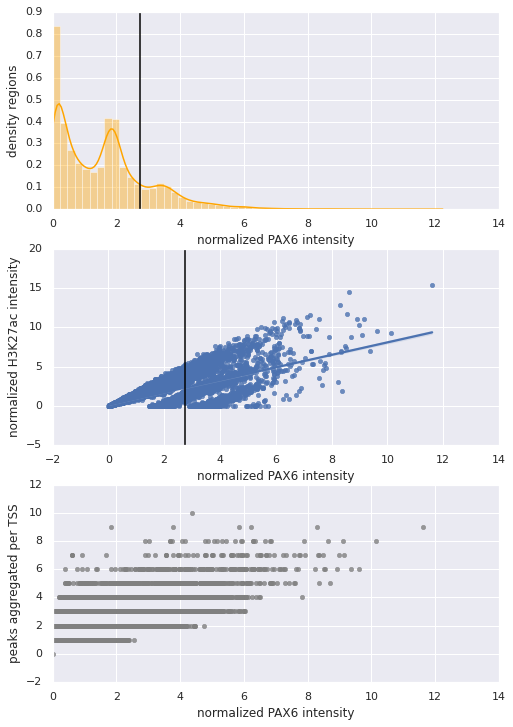

In [23]:
PAX6_int_viz = 'PAX6_both_weighted_int'
H3K27ac_int_viz = 'H3K27ac_enh_weighted_int'

TSS_PAX6_int = pd.read_table(
    f"{output_dir}/TSS_PAX6_binding_intensity.csv",
    sep=";",
    comment="#",
)

PAX6_activity_cutoff = 2.75

sns.set(rc={"figure.figsize": (8, 12)})
fig, axes = plt.subplots(3, 1)

sns.distplot(
    TSS_PAX6_int[[PAX6_int_viz]],
    #stat="probability",
    kde=True,
    color = 'orange',
    ax=axes[0],
).set(ylabel="density regions", xlabel="normalized PAX6 intensity", xlim=(0, 14))
axes[0].axvline(PAX6_activity_cutoff, 0, 1, color="black")

sns.regplot(
    y = TSS_PAX6_int[[H3K27ac_int_viz]],
    x = TSS_PAX6_int[[PAX6_int_viz]],
    ax=axes[1],
).set(ylabel="normalized H3K27ac intensity", xlabel="normalized PAX6 intensity")
axes[1].axvline(PAX6_activity_cutoff, 0, 1, color="black")

sns.regplot(
    y = TSS_PAX6_int[["n_enh"]],
    x = TSS_PAX6_int[[PAX6_int_viz]],
    ax=axes[2],
    color = 'grey',
    fit_reg = False
).set(ylabel="peaks aggregated per TSS", xlabel="normalized PAX6 intensity", xlim=(0, 14))
#axes[1].axvline(PAX6_activity_cutoff, 0, 1, color="black")



plt.savefig(f"{figure_dir}/PAX6_H3K27ac_TSS_cutoffs.pdf")


In [24]:
choices = [
    f"background_gene",
    f"PAX6 target",
]
conditions = [
    ((TSS_PAX6_int["PAX6_both_weighted_int"] < PAX6_activity_cutoff)),
    ((TSS_PAX6_int["PAX6_both_weighted_int"] > PAX6_activity_cutoff)),
]

TSS_PAX6_int[f"annotation"] = np.select(
    conditions, choices, default="annotation_missing"
)

TSS_PAX6_int.to_csv(
    f"{output_dir}/TSS_PAX6_binding_intensity_annotated.csv",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep=";",
    header=True,
    index=False,
)
TSS_PAX6_int.annotation.value_counts()

background_gene    10236
PAX6 target         2263
Name: annotation, dtype: int64

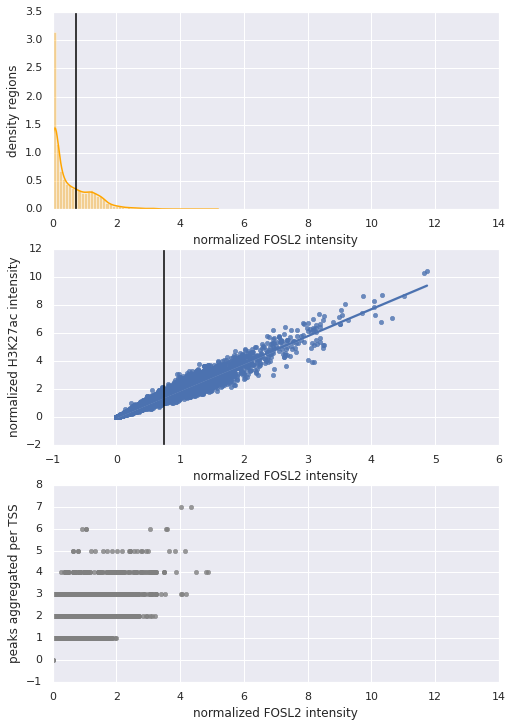

In [42]:
FOSL2_int_viz = 'FOSL2_enh_int'
H3K27AC_int_viz = 'H3K27AC_enh_weighted_int'

TSS_FOSL2_int = pd.read_table(
    f"{output_dir}/TSS_FOSL2_binding_intensity.csv",
    sep=";",
    comment="#",
)

FOSL2_activity_cutoff = 0.75

sns.set(rc={"figure.figsize": (8, 12)})
fig, axes = plt.subplots(3, 1)

sns.distplot(
    TSS_FOSL2_int[[FOSL2_int_viz]],
    #stat="probability",
    kde=True,
    color = 'orange',
    ax=axes[0],
).set(ylabel="density regions", xlabel="normalized FOSL2 intensity", xlim=(0, 14))
axes[0].axvline(FOSL2_activity_cutoff, 0, 1, color="black")

sns.regplot(
    y = TSS_FOSL2_int[[H3K27AC_int_viz]],
    x = TSS_FOSL2_int[[FOSL2_int_viz]],
    ax=axes[1],
).set(ylabel="normalized H3K27ac intensity", xlabel="normalized FOSL2 intensity")
axes[1].axvline(FOSL2_activity_cutoff, 0, 1, color="black")

sns.regplot(
    y = TSS_FOSL2_int[["n_enh"]],
    x = TSS_FOSL2_int[[FOSL2_int_viz]],
    ax=axes[2],
    color = 'grey',
    fit_reg = False
).set(ylabel="peaks aggregated per TSS", xlabel="normalized FOSL2 intensity", xlim=(0, 14))
#axes[1].axvline(PAX6_activity_cutoff, 0, 1, color="black")



plt.savefig(f"{figure_dir}/FOSL2_H3K27AC_TSS_cutoffs.pdf")


Lets annotate the genes based on these cutoffs

In [43]:
choices = [
    f"background_gene",
    f"FOSL2 target",
]
conditions = [
    ((TSS_FOSL2_int["FOSL2_both_weighted_int"] < FOSL2_activity_cutoff)),
    ((TSS_FOSL2_int["FOSL2_both_weighted_int"] > FOSL2_activity_cutoff)),
]

TSS_FOSL2_int[f"annotation"] = np.select(
    conditions, choices, default="annotation_missing"
)

TSS_FOSL2_int.to_csv(
    f"{output_dir}/TSS_FOSL2_binding_intensity_annotated.csv",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep=";",
    header=True,
    index=False,
)
TSS_FOSL2_int.annotation.value_counts()


background_gene    3939
FOSL2 target       3148
Name: annotation, dtype: int64

In [34]:
TSS_PAX6_int.to_csv(
    f"{output_dir}/TSS_PAX6_binding_intensity_annotated.csv",
    # f"{output_dir}/H3K27me3_TSS_window.bed",
    sep=";",
    header=True,
    index=False,
)

In [35]:
TSS_PAX6_int[TSS_PAX6_int.annotation == "PAX6 target"].gene_name.to_csv(
    f"{output_dir}/PAX6_target_genes.txt",
    sep=";",
    header=False,
    index=False,
)